<a href="https://colab.research.google.com/github/archivesunleashed/notebooks/blob/master/parquet_text_analyis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Archives Unleashed Web Pages Parquet Derivative

In this notebook, we'll setup an enviroment, then download a dataset of web archive collection derivatives that were produced with the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). These derivatives are in the [Apache Parquet](https://parquet.apache.org/) format, which is a [columnar storage](http://en.wikipedia.org/wiki/Column-oriented_DBMS) format. These derivatives are generally small enough to work with on your local machine.

The Parquet derivative for this notebook is the **Web Pages** one:

`.webpages()` 

Produces a DataFrame with the following columns:
  - `crawl_date`
  - `url`
  - `mime_type_web_server`
  - `mime_type_tika`
  - `language`
  - `content`

We recommend running through the notebook with the provided sample dataset. You may then want to substitute it with your own dataset.

# Dataset

First, we will need a web archive dataset to work with.

The one we'll use in this example notebook comes from [Bibliothèque et Archives nationales du Québec](https://www.banq.qc.ca/accueil/). It is a web archive collection of the Ministry of Environment of Québec (2011-2014), that has been  processed by the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). Merci beaucoup BAnQ!

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3605525.svg)](https://doi.org/10.5281/zenodo.3605525)

Curious about the size of the derivative Parquet output compared to the size of the web archive collection?

The total size of all 12 Parquet deriatives is 594M, with `webpages` being the largest (525M) since it has a column with full text (`content`).

```
2.5M	./videos
344K	./domains
1.7M	./word-processor-files
24K	./presentation-program-files
1.7M	./spreadsheets
880K	./audio
4.4M	./images
528M	./webpages
1.7M	./text-files
3.9M	./pdfs
29M	./webgraph
22M	./imagelinks
594M	.
```

The total size of the web archive collection is 165G. The derivative file is thus a 99.68% decrease!

The following command downloads all of the parquets file from the Zenodo data repository. To run a 'cell,' you can click the play button next to the cell or you can press your `shift` key and `enter` key at the same time.

Whenever you see code snippets like this, you should do the same thing to run it.

In [0]:
%%capture

!curl -L "https://zenodo.org/record/3605525/files/environnement-qc.tar.gz?download=1" > environment-qc-parquet.tar.gz
!tar -xzf environment-qc-parquet.tar.gz

The following command provides a list of all the downloaded parquet files. You should see `webpages` in there. That's what we'll be working with!

In [3]:
!ls -1 parquet

audio
domains
imagelinks
images
pdfs
presentation-program-files
spreadsheets
text-files
videos
webgraph
webpages
word-processor-files


# Environment

Next, we'll setup our environment so we can work with the Parquet output with PySpark. We use PySpark a lot here in the first part of the notebook because of the computationally intense nature of the work we are doing. 

This can be seen as a use case for when to turn to PySpark over Pandas, since we need to take full advantage of the limited compute resources available in Google Colab to do tokenization. Running the tokenization on the DataFrame in parallel with PySpark and MLlib takes a few seconds, whereas running the tokenization with Pandas and NLTK takes ~26 minutes. Using SpaCy times the notebook out -- it is simply too big!

Later in the notebook, we'll take advantage of being able to convert a PySpark DataFrame to a Pandas DataFrame to plot some items, and create a word cloud.

Confused? It's just important to remember that PySpark does the heavy computational lifting --- helping you get your data small enough that Pandas can begin to step in.

### Setup PySpark

The following commands download and install PySpark.

In [0]:
%%capture

!apt-get update
!apt-get install -y openjdk-8-jdk-headless -qq 
!apt-get install maven -qq

!curl -L "https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz" > spark-2.4.4-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Loading our pages derivative as a DataFrame

Now that PySpark is set up and the `webpages` parquet file is on our system, it's time to work with it.

We'll start by loading up the dataset to work with, and show a preview so we can get an overview of what's there and importantly, make sure that everything is working. 

Notice in the output below that we have a mix of French and English content.

In [8]:
pages = spark.read.parquet("parquet/webpages")
pages.show()

+----------+--------------------+--------------------+--------------+--------+--------------------+
|crawl_date|                 url|mime_type_web_server|mime_type_tika|language|             content|
+----------+--------------------+--------------------+--------------+--------+--------------------+
|  20190502|http://mddefp.gou...|           text/html|     text/html|      en|Schedule 4 - Sect...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|      en|Residual Hazardou...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|      en|Table de concerta...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|      en|Table de concerta...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|      en|Table de concerta...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|      en|Table de concerta...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|      en|Table de concerta...|


In [9]:
pages.count()

404580

## Text Analysis

With the `pages` derivative, we get a `content` column. This is the text of the web page, with the HTTP header information stripped out. Since we have this column, it opens up the whole world of text analysis to us!


Let's start the text analysis section by installing and importing some helpful [MLlib libraries](https://spark.apache.org/docs/2.4.4/ml-features.html#tokenizer).

In [0]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover

### Language DataFrames

Here we are going to create two new DataFrames from `pages`; `french_pages` and `english_pages`.

### Tokenization

Let's add a new column to our `pages` DataFrame that is the tokenized output of the `text` column.

Tokenization is breaking a string of text aparts into its constituative 'tokens.' For more, see https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization. 

The following commands create two new variables - one with French pages, and one with English pages. We also count them below so you can see how many of each are in the collection.


In [0]:
french_pages = pages.filter(pages['language'] == 'fr')

In [12]:
french_pages.count()

380637

In [0]:
english_pages = pages.filter(pages['language'] == 'en')

In [14]:
english_pages.count()

23641

Next, we can add some tokenization columns to each of these new DataFrames.

First, we'll setup the tokenizer, so we can use it on multiple DataFrames. 

In [0]:
tokenizer = Tokenizer(inputCol="content", outputCol="tokenized_content")
countTokens = udf(lambda tokenized_content: len(tokenized_content), IntegerType())


Now, let's run it it on each the French and English DataFrames, and add the tokens count column as well.

In [16]:
french_tokenized = tokenizer.transform(english_pages)\
                      .select("crawl_date", "url", "content", "tokenized_content")\
                      .withColumn("tokens", countTokens(col("tokenized_content")))

french_tokenized.show()

+----------+--------------------+--------------------+--------------------+------+
|crawl_date|                 url|             content|   tokenized_content|tokens|
+----------+--------------------+--------------------+--------------------+------+
|  20190502|http://mddefp.gou...|Schedule 4 - Sect...|[schedule, 4, -, ...|   862|
|  20190502|http://mddefp.gou...|Residual Hazardou...|[residual, hazard...|   448|
|  20190502|http://mddefp.gou...|Table de concerta...|[table, de, conce...|   154|
|  20190502|http://mddefp.gou...|Table de concerta...|[table, de, conce...|   152|
|  20190502|http://mddefp.gou...|Table de concerta...|[table, de, conce...|   111|
|  20190502|http://mddefp.gou...|Table de concerta...|[table, de, conce...|   149|
|  20190502|http://mddefp.gou...|Table de concerta...|[table, de, conce...|   162|
|  20190502|http://mddefp.gou...|Table de concerta...|[table, de, conce...|   155|
|  20190502|http://mddefp.gou...|Public Consultati...|[public, consulta...|   668|
|  2

In [17]:
english_tokenized = tokenizer.transform(english_pages)\
                      .select("crawl_date", "content", "url", "tokenized_content")\
                      .withColumn("tokens", countTokens(col("tokenized_content")))

english_tokenized.show()

+----------+--------------------+--------------------+--------------------+------+
|crawl_date|             content|                 url|   tokenized_content|tokens|
+----------+--------------------+--------------------+--------------------+------+
|  20190502|Schedule 4 - Sect...|http://mddefp.gou...|[schedule, 4, -, ...|   862|
|  20190502|Residual Hazardou...|http://mddefp.gou...|[residual, hazard...|   448|
|  20190502|Table de concerta...|http://mddefp.gou...|[table, de, conce...|   154|
|  20190502|Table de concerta...|http://mddefp.gou...|[table, de, conce...|   152|
|  20190502|Table de concerta...|http://mddefp.gou...|[table, de, conce...|   111|
|  20190502|Table de concerta...|http://mddefp.gou...|[table, de, conce...|   149|
|  20190502|Table de concerta...|http://mddefp.gou...|[table, de, conce...|   162|
|  20190502|Table de concerta...|http://mddefp.gou...|[table, de, conce...|   155|
|  20190502|Public Consultati...|http://mddefp.gou...|[public, consulta...|   668|
|  2

### Stop words?

We may want to remove "stop words," which are the most common words in a language that might not be useful to our analysis. For more on stop words, see https://en.wikipedia.org/wiki/Stop_words. 

The following commands load up default stopword lists for both French and English, and remove them from the token lists.

In [18]:
StopWordsRemover.loadDefaultStopWords('french')

remover = StopWordsRemover(inputCol="tokenized_content", outputCol="tokenized_content_filtered")

french_stopwords = remover.transform(french_tokenized).withColumn("filted_tokens", countTokens(col("tokenized_content_filtered")))

french_stopwords.show()

+----------+--------------------+--------------------+--------------------+------+--------------------------+-------------+
|crawl_date|                 url|             content|   tokenized_content|tokens|tokenized_content_filtered|filted_tokens|
+----------+--------------------+--------------------+--------------------+------+--------------------------+-------------+
|  20190502|http://mddefp.gou...|Schedule 4 - Sect...|[schedule, 4, -, ...|   862|      [schedule, 4, -, ...|          677|
|  20190502|http://mddefp.gou...|Residual Hazardou...|[residual, hazard...|   448|      [residual, hazard...|          320|
|  20190502|http://mddefp.gou...|Table de concerta...|[table, de, conce...|   154|      [table, de, conce...|          132|
|  20190502|http://mddefp.gou...|Table de concerta...|[table, de, conce...|   152|      [table, de, conce...|          129|
|  20190502|http://mddefp.gou...|Table de concerta...|[table, de, conce...|   111|      [table, de, conce...|           98|
|  20190

In [19]:
StopWordsRemover.loadDefaultStopWords('english')

remover = StopWordsRemover(inputCol="tokenized_content", outputCol="tokenized_content_filtered")

english_stopwords = remover.transform(english_tokenized).withColumn("filted_tokens", countTokens(col("tokenized_content_filtered")))

english_stopwords.show()

+----------+--------------------+--------------------+--------------------+------+--------------------------+-------------+
|crawl_date|             content|                 url|   tokenized_content|tokens|tokenized_content_filtered|filted_tokens|
+----------+--------------------+--------------------+--------------------+------+--------------------------+-------------+
|  20190502|Schedule 4 - Sect...|http://mddefp.gou...|[schedule, 4, -, ...|   862|      [schedule, 4, -, ...|          677|
|  20190502|Residual Hazardou...|http://mddefp.gou...|[residual, hazard...|   448|      [residual, hazard...|          320|
|  20190502|Table de concerta...|http://mddefp.gou...|[table, de, conce...|   154|      [table, de, conce...|          132|
|  20190502|Table de concerta...|http://mddefp.gou...|[table, de, conce...|   152|      [table, de, conce...|          129|
|  20190502|Table de concerta...|http://mddefp.gou...|[table, de, conce...|   111|      [table, de, conce...|           98|
|  20190

### Basic word count statistics with PySpark!

The following set of commands provides some basic information on the words found within the web archive: maximum, mean, minimum numbers of words throughout the collection.

The idea here is to get a sense of how to run some basic statistics available to us in PySpark, and maybe inspire some more questions to ask a dataset like this. Also, take note as to how long each one takes here, since we'll do the same below with Pandas. Which one will be faster?


In [0]:
from pyspark.sql.functions import col, avg, stddev, mean, max, min

#### Mean

In [21]:
french_stopwords.select(mean('tokens')).show()

+-----------------+
|      avg(tokens)|
+-----------------+
|637.9291485131763|
+-----------------+



In [22]:
english_stopwords.select(mean('tokens')).show()

+-----------------+
|      avg(tokens)|
+-----------------+
|637.9291485131763|
+-----------------+



#### Standard deviation

In [23]:
french_stopwords.select(stddev('tokens')).show()

+-------------------+
|stddev_samp(tokens)|
+-------------------+
|  771.4478462315645|
+-------------------+



In [24]:
english_stopwords.select(stddev('tokens')).show()

+-------------------+
|stddev_samp(tokens)|
+-------------------+
|  771.4478462315645|
+-------------------+



#### Max

In [25]:
french_stopwords.select(max('tokens')).show()

+-----------+
|max(tokens)|
+-----------+
|       9376|
+-----------+



In [26]:
english_stopwords.select(max('tokens')).show()

+-----------+
|max(tokens)|
+-----------+
|       9376|
+-----------+



#### Min

In [27]:
french_stopwords.select(min('tokens')).show()

+-----------+
|min(tokens)|
+-----------+
|          1|
+-----------+



In [28]:
french_stopwords.select(min('tokens')).show()

+-----------+
|min(tokens)|
+-----------+
|          1|
+-----------+



## Can we convert the PySpark DataFrames to a Pandas DataFrames?

**Yes**! `.toPandas()` is our friend!

Why would we want to do this? Now that we've done some heavy lifting in PySpark, it is time to switch over to Pandas. Pandas is an open-source data science laboratory - you can read about it at https://pandas.pydata.org.

The following commands load Pandas, and then turn them into a DataFrame.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
french_pages_pd = french_stopwords.toPandas()
french_pages_pd

Py4JJavaError: ignored

In [35]:
english_pages_pd = english_stopwords.toPandas()
english_pages_pd

Py4JJavaError: ignored

### Basic word count statistics with Pandas!

Now we can use the power of Pandas to find some basic statistical data!

Notice how the Pandas method looks a little cleaner, and is a little bit faster?

#### Mean

In [31]:
french_pages_pd['tokens'].mean()

637.9291485131763

In [32]:
english_pages_pd['tokens'].mean()

NameError: ignored

#### Standard deviation

In [36]:
french_pages_pd['tokens'].std()

771.447846231566

In [0]:
english_pages_pd['tokens'].std()

#### Max

In [37]:
french_pages_pd['tokens'].max()

9376

In [0]:
english_pages_pd['tokens'].max()

#### Min

In [38]:
french_pages_pd['tokens'].min()

1

In [0]:
english_pages_pd['tokens'].min()

### Pages with the most words

Let's create a bar chart that shows the pages with the most words. Here we can see the power of Pandas at work, in terms of both analysis and visualization.

First, let's show the query to get the data for our chart.




In [0]:
french_word_count_df = french_pages_pd[['url', 'tokens']].sort_values(by='tokens', ascending=False).head(25)

In [0]:
english_word_count_df = english_pages_pd[['url', 'tokens']].sort_values(by='tokens', ascending=False).head(25)

Next, let's create a bar chart of this.

Text(0.5, 0, 'Page')

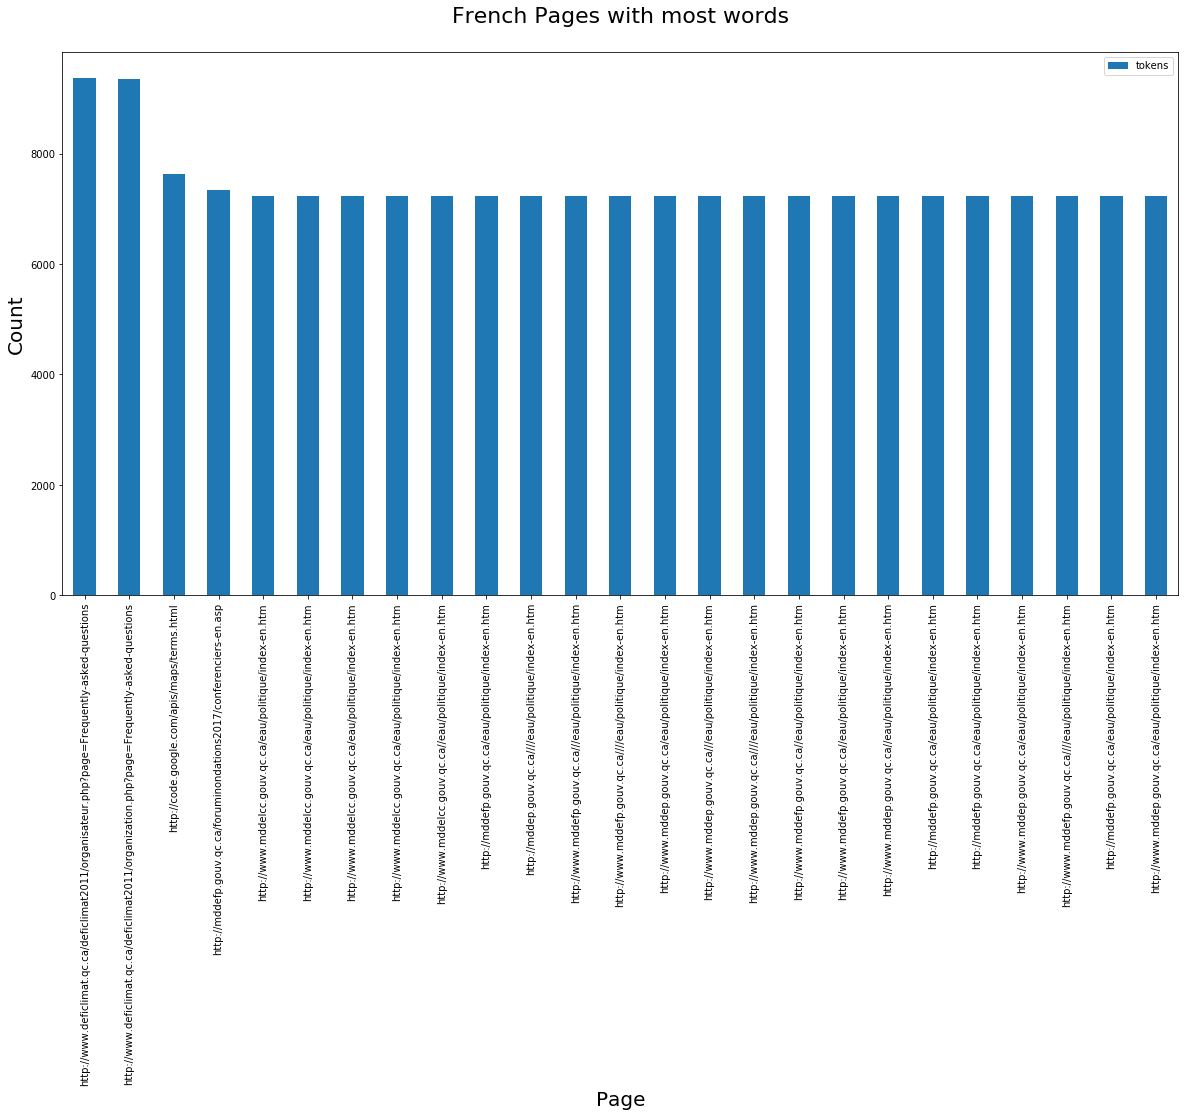

In [40]:
french_word_count_chart = french_word_count_df.plot(kind='bar', x='url', figsize=(20,10))
french_word_count_chart.set_title('French Pages with most words\n', fontsize=22)
french_word_count_chart.set_ylabel('Count', fontsize=20)
french_word_count_chart.set_xlabel('Page', fontsize=20)


In [0]:
english_word_count_chart = english_word_count_df.plot(kind='bar', x='url', figsize=(20,10))
english_word_count_chart.set_title('English Pages with most words\n', fontsize=22)
english_word_count_chart.set_ylabel('Count', fontsize=20)
english_word_count_chart.set_xlabel('Page', fontsize=20)

## How about NER on the two pages with the most tokens?

[Named-Entity Recognition](https://en.wikipedia.org/wiki/Named-entity_recognition), or NER, is an exciting field of natural language processing that lets us extract "entities" out of text. This might be the names of people, locations, or organizations. 

To do this, we first need to find the pages that have the most tokens.

In [0]:
pd.set_option('display.max_colwidth', -1)

In [42]:
french_word_count_max = french_pages_pd[['url', 'tokens', "content"]].sort_values(by='tokens', ascending=False).head(1)
french_word_count_max['url']

12973    http://www.deficlimat.qc.ca/deficlimat2011/organisateur.php?page=Frequently-asked-questions
Name: url, dtype: object

In [33]:
english_word_count_max = english_pages_pd[['url', 'tokens', "content"]].sort_values(by='tokens', ascending=False).head(1)
english_word_count_max['url']

NameError: ignored

Since these are both the same url, let's just stick with one to keep things simple here.

In [0]:
page = english_word_count_max['content'].astype('unicode').to_string()
page

"12973    D�fi Climat 2011 -   2 \xa0Section : \xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0\xa0\xa0\xa0 M�dia\xa0\xa0|\xa0 Contactez-nous\xa0\xa0|\xa0\xa0 English Home Défi Climat Changements climatiques L’effet de serre Les impacts Les impacts au Québec Les sources de GES au Québec Les sources de GES au Canada Organisations Inscrire une organisation Ouvrir une session Organisations participantes Gestes corporatifs et ressources D�fis collectifs Foire aux questions Citoyens Inscription Gestes citoyens Ressources Dévoilez vos trucs Prix � gagner �coles et �l�ves Inscription des jeunes Gestes jeunesse Outils p�dagogiques Prix � gagner Inscription d�une �cole Comptabiliser les inscriptions de vos �l�ves Partout au Québec Frequently asked questions What is Défi Climat? What are the factors of success for Défi Climat? What issues does Défi Climat address? How are actions quantified? What interest is there in Défi Climat? What are the goals of Défi Climat? What are the results of former campaign? Why d

### Setup SpaCy

We now need to set up [spaCy](https://en.wikipedia.org/wiki/SpaCy), a [natural-language processing toolkit. 

After installing it, the command will run NER on the text. Watch how it finds organizations, people, and beyond!

In [0]:
import spacy
from spacy import displacy

import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [0]:
ner = nlp(page)
displacy.render(ner, style='ent', jupyter=True)

### Word Cloud

Word clouds are always fun, right?! They're an interesting way to visualize word frequency, as the more times that a word appears, the larger it will appear in the word cloud.

Let's setup some dependcies here, and install the [`word_cloud`](https://github.com/amueller/word_cloud) library, and setup some stop words via `nltk`.

We'll take about 50% of the dataset here since we're limited by RAM.


In [0]:
%%capture

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


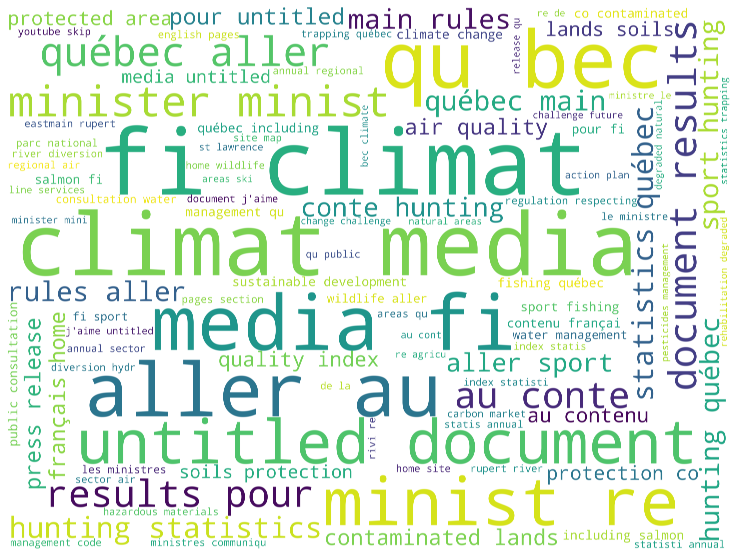

In [0]:
french_wordcloud = WordCloud(width=2000, height=1500, scale=10, max_font_size=250, max_words=100, background_color="white").generate((french_pages_pd['tokenized_content_filtered']).to_string())
plt.figure(figsize=[35,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

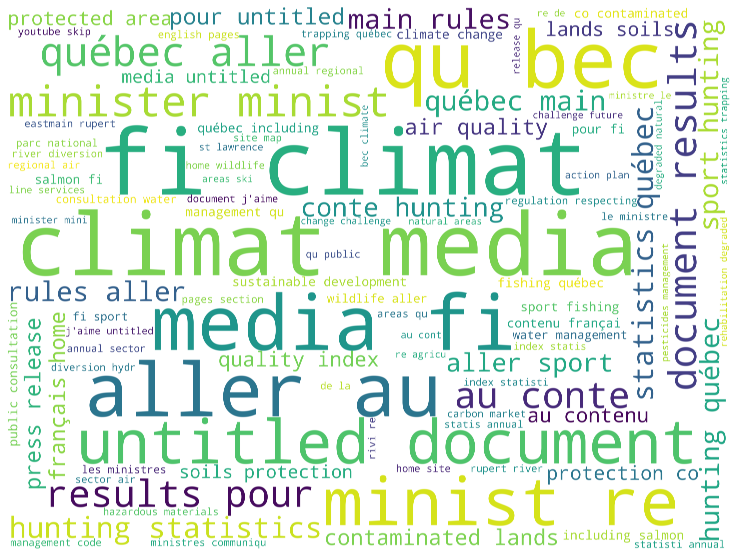

In [0]:
english_wordcloud = WordCloud(width=2000, height=1500, scale=10, max_font_size=250, max_words=100, background_color="white").generate((english_pages_pd['tokenized_content_filtered']).to_string())
plt.figure(figsize=[35,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()